In [1]:
import numpy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.utils.data as Data
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

data=pd.read_excel('C:/Users/XHM/Desktop/data/TFT/trainlog.xlsx',engine='openpyxl')
all_input=data[['Vg','Vd','W/L']].values
all_output=data[['Id1','gm1','gd1']].values
z=preprocessing.StandardScaler()
#all_output=minmax.fit_transform(data['Idrain'].values.reshape(-1,1))

(x_train,x_test,y_train,y_test)=train_test_split(all_input,all_output,train_size=0.8,
                                                 random_state=0)
a=np.std(x_train, axis = 0)
print(a)
#标准化处理
x_train=z.fit_transform(x_train)
x_test=z.transform(x_test)
#z.inverse_transform



#数据类型处理
train_xt=torch.from_numpy(x_train.astype(np.float32))
train_yt=torch.from_numpy(y_train.astype(np.float32))
test_xt=torch.from_numpy(x_test.astype(np.float32))
test_yt=torch.from_numpy(y_test.astype(np.float32))
#将数据处理为数据加载器
train_data=Data.TensorDataset(train_xt,train_yt.float())
test_data=Data.TensorDataset(test_xt,test_yt.float())

train_loader=Data.DataLoader(dataset=train_data,batch_size=32,shuffle=True,num_workers=0)
test_loader=Data.DataLoader(dataset=test_data,batch_size=32,shuffle=False,num_workers=0)



[7.76789725 6.90964793 1.93920457]


In [2]:
class MLPregression(nn.Module):
    def __init__(self,p):
        super(MLPregression,self).__init__()
        self.p=torch.from_numpy(p)
        self.p = self.p.to(torch.float32)
        #self.p=p
        self.activate=nn.Sigmoid()
        #定义第一个隐藏层
        self.input=nn.Linear(in_features=3,out_features=15,bias=True)
        #定义第二个隐藏层
        self.hidden2=nn.Linear(15,8)
        #回归预测层
        self.predict=nn.Linear(8,1)
        #取出权重
        self.input.weight.data=self.p[0:45].reshape((15,3))
        self.input.bias.data=self.p[45:60].reshape((15,))
        self.hidden2.weight.data=self.p[60:180].reshape((8,15))
        self.hidden2.bias.data=self.p[180:188].reshape((8,))
        self.predict.weight.data=self.p[188:196].reshape((1,8))
        self.predict.bias.data=self.p[196:197]
    def forward(self,x):
        x=self.activate(self.input(x))
        x=self.activate(self.hidden2(x))
        output=self.predict(x)
        return output[:,0]

#mlpreg.load_state_dict(torch.load("C:/Users/XHM/LEVIST/DIST/mlp_init_nosgd.pth"))
def loss_function(id_pre,ids,g_pre,gm,gd):
    loss_func=nn.MSELoss()
    gm_pre=g_pre[:,0]
    gd_pre=g_pre[:,1]
    for i in range(len(gm)):
        if gm[i]==0:
            gm_pre[i]=0
        elif gd[i]==0:
            gd_pre[i]=0
    j=0.9*(loss_func(id_pre,ids)+0.1*loss_func(gm_pre,gm)+0.1*loss_func(gd_pre,gd))
    return j

def fitness(x):
    mlpreg=MLPregression(p=x) 
    train_loss_all=[]
    for step,(b_x,b_y) in enumerate(train_loader):
        output=mlpreg(b_x)
        
        b_x.requires_grad_(True)
        y=mlpreg(b_x)
        y.retain_grad()
        b_x.grad
        y.backward(torch.ones_like(y))
        g_pre=b_x.grad
        g_pre=g_pre*(1/a)
       
        loss=loss_function(output,b_y[:,0],g_pre,b_y[:,1],b_y[:,2])
    return loss.item()

In [3]:
from sko.GA import GA
ga = GA(func=fitness, n_dim=197, size_pop=200, max_iter=800, lb=[0.001]*197, ub=[10]*197, precision=1e-7)
#ga.register(operator_name='selection', operator=selection_tournament, tourn_size=3)
best_x, best_y = ga.run()
print('best_x:', best_x, '\n', 'best_y:', best_y)

best_x: [9.35926333 4.83468301 7.72148052 3.00795382 0.97866599 5.93558314
 9.32589433 1.73882889 0.64723055 3.86207174 5.11071209 0.04002477
 5.55582382 6.75799589 9.96215253 0.25217337 1.43318835 5.36496387
 6.31581403 1.86781608 0.90424682 4.02226302 0.91443902 5.10701883
 1.50417381 4.62476885 0.48379755 8.57290659 8.82377906 5.64346331
 3.05107481 7.99785385 7.1900316  1.43295525 3.97631556 1.88716614
 8.24019678 9.68458342 3.33869389 2.7439917  6.27817917 6.07394387
 0.01708844 8.21769664 4.38561974 7.66239319 9.3729124  7.86994874
 5.77592109 8.68884585 6.04962611 5.58688949 2.77775956 4.2892401
 2.09259275 3.78196969 9.38797261 1.62251937 8.64945849 1.64512158
 0.10220423 9.34746711 9.06384375 2.47521995 7.52374199 1.34267255
 7.47802027 8.8183295  0.16593146 5.07870789 3.64022949 4.34089405
 5.29914309 6.39176414 6.4293341  2.06769227 0.45622474 0.36242408
 8.67477497 8.1715356  6.34506685 5.44173875 2.39480971 8.19432919
 8.22440261 9.89558817 6.41576386 2.2858841  0.56556582

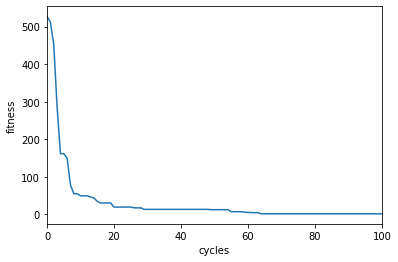

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

torch.save(best_x,"F:/TFT_FINAL/ga.best_x.pth")
Y_history = pd.DataFrame(ga.all_history_Y)
Y_history.min(axis=1).cummin().plot(kind='line')
plt.xlabel("cycles")
plt.xlim((0,100))
plt.ylabel("fitness")
plt.show()

## 遗传算法


In [7]:
g=torch.load("F:/TFT_FINAL/ga.best_x.pth")   # 加载出这个参数
g=torch.Tensor(g)
t = g.to(torch.float32)
#t=b
class MLPregression(nn.Module):
    def __init__(self):
        super(MLPregression,self).__init__()
        
        self.activate=nn.Sigmoid()
        #定义第一个隐藏层
        self.input=nn.Linear(in_features=3,out_features=15,bias=True)
        #定义第二个隐藏层
        self.hidden2=nn.Linear(15,8)
        #回归预测层
        self.predict=nn.Linear(8,1)
        #取出权重
        self.input.weight.data=t[0:45].reshape((15,3))
        self.input.bias.data=t[45:60].reshape((15,))
        self.hidden2.weight.data=t[60:180].reshape((8,15))
        self.hidden2.bias.data=t[180:188].reshape((8,))
        self.predict.weight.data=t[188:196].reshape((1,8))
        self.predict.bias.data=t[196:197]
    def forward(self,x):
        x=self.activate(self.input(x))
        x=self.activate(self.hidden2(x))
        output=self.predict(x)
        return output[:,0]
mlp=MLPregression()
torch.save(mlp.state_dict(),"F:/TFT_FINAL/ga02.pth") 